<a href="https://colab.research.google.com/github/rahiakela/modern-computer-vision-with-pytorch/blob/main/8-advanced-object-detection/3_training_ssd_based_custom_object_detectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Training SSD on a custom object detectors

The workings behind how SSD helps overcome the issue of detecting objects with
different scales is as follows:

- We leverage the pre-trained VGG network and extend it with a few
additional layers until we obtain a 1 x 1 block.
- Instead of leveraging only the final layer for bounding box and class
predictions, we will leverage all of the last few layers to make class and
bounding box predictions.
- In place of anchor boxes, we will come up with default boxes that have a
specific set of scale and aspect ratios.
- Each of the default boxes should predict the object and bounding box offset
just like how anchor boxes are expected to predict classes and offsets in
YOLO.

In this notebook, we will learn about the working details of SSD before training it on our custom dataset.

## Setup

In [ ]:
!pip install torch_snippets

The core utility functions for this section are present in the GitHub repo: https://github.com/sizhky/ssd-utils/

In [ ]:
%%shell

git clone https://github.com/sizhky/ssd-utils/

In [3]:
from torch_snippets import *
from torchvision.ops import nms
import collections, os, torch
import torchvision
from torchvision import transforms

from sklearn.model_selection import train_test_split

from model import SSD300, MultiBoxLoss
from detect import *

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'

%matplotlib inline

## Working details of SSD

Now that we understand the main ways in which SSD differs from YOLO (which is
that default boxes in SSD replace anchor boxes in YOLO and multiple layers are
connected to the final layer in SSD, instead of gradual convolution pooling in YOLO).

Let's learn about the following:

- The network architecture of SSD
- How to leverage different layers for bounding box and class predictions
- How to assign scale and aspect ratios for default boxes in different layers

<img src='https://github.com/rahiakela/img-repo/blob/master/object-detection-images/SSD-architecture.png?raw=1' width='800'/>

We are taking an image of size `300 x 300 x 3` and passing it through a pre-trained VGG-16 network to obtain the `conv5_3` layer's output. Furthermore, we are extending the network by adding a few more convolutions to the `conv5_3` output.

Next, we obtain a bounding box offset and class prediction for each cell and each default box (more on default boxes in the next section; for now, let's imagine that this is similar to an anchor box). The total number of predictions coming from the `conv5_3` output is `38 x 38 x 4`, where `38 x 38` is the output shape of the `conv5_3` layer and 4 is the number of default boxes operating on the `conv5_3` layer.

<img src='https://github.com/rahiakela/img-repo/blob/master/object-detection-images/ssd-parameters.png?raw=1' width='800'/>

Now, let's learn about the different scales and aspect ratios of default boxes. We will start with scales and then proceed to aspect ratios.

Let's imagine a scenario where the minimum scale of an object is 20% of the height and 20% of the width of an image, and the maximum scale of the object is 90% of the height and 90% of the width. In such a scenario, we gradually increase scale across layers (as we proceed toward later layers, the image size shrinks considerably).


<img src='https://github.com/rahiakela/img-repo/blob/master/object-detection-images/gradual-scaling.png?raw=1' width='800'/>

The formula that enables the gradual scaling of the image is as follows:

$$ level \space index : l = 1, ..., L $$
$$ scale \space of \space boxes: s_l = s_{min} + \frac{s_{max} - s_{min}}{L - 1}(l -1) $$

Now that we understand how to calculate scale across layers, we will now learn
about coming up with boxes of different aspect ratios.

The possible aspect ratios are as follows:

$$ aspect \space ratio : r \in {1, 2, 3, 1/2, 1/3} $$

The center of the box for different layers are as follows:

$$ center \space location : (x_l^i, y_l^j) = (\frac{i + 0.5}{m}, \frac{j+0.5}{n}) $$


Here $i$ and $j$ together represent a cell in layer $l$.

The width and height corresponding to different aspect ratios are calculated as follows:

$$ width: w_l^r = s_l\sqrt{r} $$


$$ height: h_l^r = s_l\sqrt{r} $$

Note that we were considering four boxes in certain layers and six boxes in another layer. Now, if we want to have four boxes, we remove the {3,1/3} aspect ratios, else we consider all of the six possible boxes (five boxes with the same scale and one box with a different scale).

$$ additional \space scale : S_t = \sqrt{S_l \space S_{l + 1}} \space when \space r = 1 $$

The default boxes that have an IoU greater than a threshold (say, 0.5) are considered positive matches, and the rest are negative matches.

In the output of SSD, we predict the probability of the box belonging to a class (where the 0th class represents the background) and also the offset of the ground truth with respect to the default box.

Finally, we train the model by optimizing the following loss values:

- **Classification loss**: This is represented using the following equation:
$$ L_{cls} = - \sum_{i \in pos} 1_{ij}^k \space log(c_i^k) - \sum_{i \in neg} log(c_i^0), \space where \space c_i^k = softmax(c_i^k)$$
In the preceding equation, pos represents the few default boxes that have a
high overlap with the ground truth, while neg represents the misclassified
boxes that were predicting a class but in fact did not contain an object.
Finally, we ensure that the pos:neg ratio is at most 1:3, as if we do not
perform this sampling, we would have a dominance of background class
boxes.

- **Localization loss**: For localization, we consider the loss values only when the objectness score is greater than a certain threshold. The localization loss is calculated as follows:
<img src='https://github.com/rahiakela/img-repo/blob/master/object-detection-images/localization_loss.png?raw=1' width='800'/>









## Components in SSD

There are three files in the GitHub repo. Let's dig into them a little and understand them before training.

We are importing the SSD300 and MultiBoxLoss classes from the model.py file in
the GitHub repository.

**SSD300**

When you look at the SSD300 function definition, it is evident that the model
comprises three sub-modules:

```python
class SSD300(nn.Module):
  ...
  def __init__(self, n_classes, device):
    ...
    self.base = VGGBase()
    self.aux_convs = AuxiliaryConvolutions()
    self.pred_convs = PredictionConvolutions(n_classes)
    ...
```

We send the input to VGGBase first, which returns two feature vectors of
dimensions `(N, 512, 38, 38)` and `(N, 1024, 19, 19)`. The second output is
going to be the input for AuxiliaryConvolutions, which returns more feature
maps of dimensions `(N, 512, 10, 10), (N, 256, 5, 5), (N, 256, 3, 3)`,
and `(N, 256, 1, 1)`. Finally, the first output from VGGBase and these four feature maps are sent to PredictionConvolutions, which returns `8,732` anchor boxes.

The other key aspect of the SSD300 class is the create_prior_boxes method. For
every feature map, there are three items associated with it: the size of the grid, the scale to shrink the grid cell by (this is the base anchor box for this feature map), and the aspect ratios for all anchors in a cell. Using these three configurations, the code uses a triple for loop and creates a list of (cx, cy, w, h) for all 8,732 anchor boxes.

Finally, the detect_objects method takes tensors of classification and regression values (of the predicted anchor boxes) and converts them to actual bounding box coordinates.

**MultiBoxLoss**

As humans, we are only worried about a handful of bounding boxes. But for the way SSD works, we need to compare 8,732 bounding boxes from several feature maps and predict whether an anchor box contains valuable information or not. We assign this loss computation task to MultiBoxLoss.

The input for the forward method is the anchor box predictions from the model and the ground truth bounding boxes.

First, we convert the ground truth boxes into a list of 8,732 anchor boxes by
comparing each anchor from the model with the bounding box. If the IoU is high
enough, that particular anchor box will have non-zero regression coordinates and associates an object as the ground truth for classification. Naturally, most of the computed anchor boxes will have their associated class as background because their IoU with the actual bounding box will be tiny or, in quite a few cases, zero.

Once the ground truths are converted to these 8,732 anchor box regression and
classification tensors, it is easy to compare them with the model's predictions since the shapes are now the same.

We perform MSE-Loss on the regression tensor and CrossEntropy-Loss on the
localization tensor and add them up to be returned as the final loss.




## Downloading the dataset

For the scenario of object detection, we will download the data from Kaggle that is the Google Open Images v6 dataset.

However, we will work on only those images that are of a bus or a truck to ensure that we can train images (as you will shortly notice the memory issues associated with using selectivesearch).



In [4]:
from google.colab import files
files.upload() # upload kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rahiakela","key":"484f91b2ebc194b0bff8ab8777c1ebff"}'}

In [5]:
%%shell

mkdir -p ~/.kaggle
mv kaggle.json ~/.kaggle/
ls ~/.kaggle
chmod 600 /root/.kaggle/kaggle.json

# download dataset from kaggle
kaggle datasets download -d sixhky/open-images-bus-trucks/
unzip -qq open-images-bus-trucks.zip
rm open-images-bus-trucks.zip

cp -r df.csv ssd-utils

kaggle.json
 96% 353M/367M [00:03<00:00, 111MB/s]
100% 367M/367M [00:03<00:00, 115MB/s]


In [6]:
%cd ssd-utils

Cloning into 'ssd-utils'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), done.
/content/ssd-utils


## Preparing the dataset

Now that we have downloaded the dataset, we will prepare the dataset. This involves the following steps:

1. Fetching each image and its corresponding class and bounding box values
2. Fetching the region proposals within each image, their corresponding IoU, and the delta by which the region proposal is to be corrected with respect to the ground truth
3. Assigning numeric labels for each class (where we have an additional background class (besides the bus and truck classes) where IoU with the ground truth bounding box is below a threshold)
4. Resizing each region proposal to a common size in order to pass them to a network

By the end of this exercise, we will have resized crops of region proposals, along with assigning the ground truth class to each region proposal, and calculated the offset of the region proposal in relation to the ground truth bounding box. 

Specify the location of images and read the ground truths present in the CSV file that we downloaded:

In [27]:
IMAGE_ROOT = "../images/images/"
DF_RAW = df = pd.read_csv("../df.csv")
print(DF_RAW.head())

Define the indices corresponding to labels and targets:

In [30]:
df = DF_RAW.copy()
df = df[df["ImageID"].isin(df["ImageID"].unique().tolist())]
label2target = {label: target + 1 for target, label in enumerate(df["LabelName"].unique())}
label2target["background"] = 0

target2label = {target: label for label, target in label2target.items()}
background_class = label2target["background"]
num_classes = len(label2target)
num_classes

3

In [31]:
# define transfomation
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
denormalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

In [32]:
def preprocess_image(img):
  img = torch.tensor(img).permute(2, 0, 1)
  img = normalize(img)
  
  return img.to(device).float()

Define a class that returns the image and its corresponding class and ground truth along with the file path of the image:

In [33]:
class OpenImages(Dataset):
  w, h = 300, 300
  def __init__(self, df, image_dir=IMAGE_ROOT):
    self.image_dir = image_dir
    self.files = glob.glob(self.image_dir + "/*")
    self.df = df
    self.image_infos = df.ImageID.unique()

  def __getitem__(self, idx):
    # load images and masks
    image_id = self.image_infos[idx]
    img_path = find(image_id, self.files)
    img = Image.open(img_path).convert("RGB")
    img = np.array(img.resize((self.w, self.h), resample=Image.BILINEAR))/255.
    data = df[df["ImageID"] == image_id]
    labels = data['LabelName'].values.tolist()
    data = data[['XMin','YMin','XMax','YMax']].values
    data[:,[0,2]] *= self.w
    data[:,[1,3]] *= self.h
    boxes = data.astype(np.uint32).tolist() # convert to absolute coordinates

    return img, boxes, labels

  def collate_fn(self, batch):
    images, boxes, labels = [], [], []
    for item in batch:
      img, image_boxes, image_labels = item
      img = preprocess_image(img)[None]
      images.append(img)
      boxes.append(torch.tensor(image_boxes).float().to(device)/300.)
      labels.append(torch.tensor([label2target[c] for c in image_labels]).long().to(device))
    images = torch.cat(images).to(device)

    return images, boxes, labels

  def __len__(self):
    return len(self.image_infos)

Create the training and validation dataloaders and datasets

In [34]:
df.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,0,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,0,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,0,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,0,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,0,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452


In [35]:
# Create the training and validation datasets and data loaders
train_ids, val_ids = train_test_split(df.ImageID.unique(), test_size=0.1, random_state=99)
train_df, val_df = df[df["ImageID"].isin(train_ids)], df[df["ImageID"].isin(val_ids)]
print(len(train_df), len(val_df))

In [36]:
train_ds = OpenImages(train_df)
test_ds  = OpenImages(val_df)

In [37]:
train_loader = DataLoader(train_ds, batch_size=4, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=4, collate_fn=test_ds.collate_fn, drop_last=True)

## Train the model

Define the functions to train and validate on a batch.

In [42]:
# Defining training and validation functions for a single batch
def train_batch(inputs, model, criterion, optimizer):
  model.train()

  N = len(train_loader)
  images, boxes, labels = inputs
  _regr, _clss = model(images)
  loss = criterion(_regr, _clss, boxes, labels)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  return loss

In [39]:
@torch.no_grad()  # this will disable gradient computation in the function below
def validate_batch(inputs, model, criterion):
  model.eval()

  images, boxes, labels  = inputs
  _regr, _clss = model(images)
  
  loss = criterion(_regr, _clss, boxes, labels)

  return loss

Let's initialize the model, optimizer, and loss function:

In [40]:
n_epochs = 3

model = SSD300(num_classes, device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy, device=device)

log = Report(n_epochs=n_epochs)
logs_to_print = 5


Loaded base model.



/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


We now train the model over increasing epochs.

In [43]:
for epoch in range(n_epochs):
  _n = len(train_loader)
  for ix, inputs in enumerate(train_loader):
    #print(inputs.size())
    loss  = train_batch(inputs, model, criterion, optimizer)
    pos = (epoch + (ix + 1) / _n)
    log.record(pos, trn_loss=loss.item(), end='\r')
  
  _n = len(test_loader)
  for ix, inputs in enumerate(test_loader):
    loss = validate_batch(inputs, model, criterion)
    pos = (epoch + (ix + 1) / _n)
    log.record(pos, val_loss=loss.item(), end='\r')

EPOCH: 3.000	val_loss: 1.752	(2311.84s - 0.00s remaining)

Plot the variation of the various loss values over increasing epochs:

100%|██████████| 104/104 [00:00<00:00, 308.98it/s]


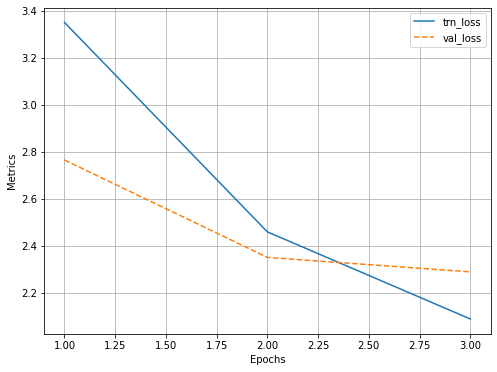

In [44]:
# Plotting training and validation metrics
log.plot_epochs(['trn_loss','val_loss'])

## Predict on a new image

Let's fetch a random image:




In [45]:
image_paths = Glob(f'../images/*')
image_id = choose(test_ds.image_infos)
img_path = find(image_id, test_ds.files)
original_image = Image.open(img_path, mode='r')
original_image = original_image.convert('RGB')

Fetch the predictions of the boxes and classes on test images:

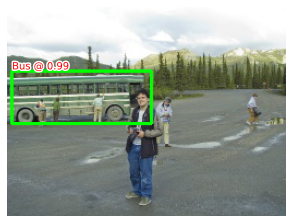

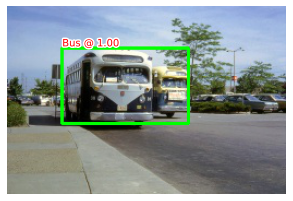

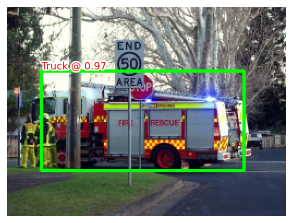

In [46]:
image_paths = Glob(f'../images/*')

for _ in range(3):
  image_id = choose(test_ds.image_infos)
  img_path = find(image_id, test_ds.files)
  original_image = Image.open(img_path, mode='r')

  # Fetch the bounding box, label, and score corresponding to the objects present in the image
  bbs, labels, scores = detect(original_image, model, min_score=0.9, max_overlap=0.5,top_k=200, device=device)

  # Overlay the obtained output on the image
  labels = [target2label[c.item()] for c in labels]
  label_with_conf = [f'{l} @ {s:.2f}' for l,s in zip(labels,scores)]
  print(bbs, label_with_conf)
  show(original_image, bbs=bbs, texts=label_with_conf, text_sz=10)

From this, we can see that we can detect objects in the image reasonably accurately.